In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pymysql
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## data load

### DB 연동

In [2]:
conn = pymysql.connect(host = "127.0.0.1", user = [USER], passwd = [PASSWORD], db = [DATABASE], cursorclass = pymysql.cursors.DictCursor)
cur = conn.cursor()

cur.execute("show databases")
print(cur.fetchall())
cur.execute("use [DATABASE]")

[{'Database': 'information_schema'}, {'Database': 'CLI'}, {'Database': 'MusicBank'}, {'Database': 'mysql'}, {'Database': 'mytestdb'}, {'Database': 'performance_schema'}, {'Database': 'sys'}]


0

### table date loading

In [3]:
query = """ 
select * from news_counting ;
"""
cur.execute(query)
news_df = pd.DataFrame(list(cur.fetchall())).drop(['id'], axis=1)
news_df

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5
0,2015,9,7,737,399,273,236,135
1,2015,9,14,701,513,274,147,226
2,2015,9,21,575,267,231,216,111
3,2015,9,28,480,248,173,129,79
4,2015,10,5,576,262,204,87,109
...,...,...,...,...,...,...,...,...
264,2020,9,28,489,90,114,95,78
265,2020,10,5,816,183,177,109,78
266,2020,10,12,857,199,176,112,91
267,2020,10,19,911,155,143,95,129


In [4]:
query = """ 
select * from portal_trends_ratio ;
"""
cur.execute(query)
portal_df = pd.DataFrame(list(cur.fetchall()))
portal_df = portal_df[['year', 'month', 'day', 'google', 'naver']][17:]

# 카카오변수 제외, 구글/네이버를 활용하기위해 네이버변수가 값을 갖는 2016년 1월부터 데이터 사용
portal_df


,year,month,day,google,naver
17,2016,1,4,53.0,26.05846
18,2016,1,11,58.0,25.16599
19,2016,1,18,74.0,27.38639
20,2016,1,25,59.0,24.72622
21,2016,2,1,63.0,23.01888
...,...,...,...,...,...
264,2020,9,28,63.0,25.29102
265,2020,10,5,81.0,28.63240
266,2020,10,12,82.0,26.85177
267,2020,10,19,93.0,27.25273


In [ ]:
## response y: CCSI(소비자심리지수)
query = """ 
select * from ccsi ;
"""
cur.execute(query)
conn.close()
cur.close()
ccsi = pd.DataFrame(list(cur.fetchall()))[4:].reset_index(drop = True)
# X와 기간을 맞춤
ccsi 

## X, y dataframe
response: CCSI, predictors: keyword1~5, google, naver

In [50]:
# predictors X: 뉴스카운팅, 포털트렌드 변수
predictors = pd.merge(news_df, portal_df)
predictors

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver
0,2016,1,4,825,419,437,986,168,53.0,26.05846
1,2016,1,11,770,348,351,626,182,58.0,25.16599
2,2016,1,18,918,422,441,445,147,74.0,27.38639
3,2016,1,25,1067,425,567,383,148,59.0,24.72622
4,2016,2,1,899,341,485,289,110,63.0,23.01888
...,...,...,...,...,...,...,...,...,...,...
247,2020,9,28,489,90,114,95,78,63.0,25.29102
248,2020,10,5,816,183,177,109,78,81.0,28.63240
249,2020,10,12,857,199,176,112,91,82.0,26.85177
250,2020,10,19,911,155,143,95,129,93.0,27.25273


In [51]:
def isLastWeekOfThisMonth(X, index):
    if(index == (len(X) - 1)):
        return True
    if ( X.iloc[index].month != X.iloc[index + 1].month ):
        return True
    return False


In [52]:
"""
같은 달의 주차별 데이터들을 저장하는 list를 초기화하는 function
"""
def initializeStacks():
    global keyword1_stack, keyword2_stack, keyword3_stack, keyword4_stack, keyword5_stack, google_stack, naver_stack
    keyword1_stack = []
    keyword2_stack = []
    keyword3_stack = []
    keyword4_stack = []
    keyword5_stack = []
    google_stack = []
    naver_stack = []


In [55]:
"""
달의 마지막 주차이면, 해당 달의 데이터들의 평균값들을 하나의 record로 갖는 dataframe 생성
"""
def getXdataframe(X):
    initializeStacks()
    X_monthly = pd.DataFrame()
    for i in range(len(X)):
        keyword1_stack.append(X.iloc[i].keyword1)
        keyword2_stack.append(X.iloc[i].keyword2)
        keyword3_stack.append(X.iloc[i].keyword3)
        keyword4_stack.append(X.iloc[i].keyword4)
        keyword5_stack.append(X.iloc[i].keyword5)
        google_stack.append(X.iloc[i].google)
        naver_stack.append(X.iloc[i].naver)

        if ( isLastWeekOfThisMonth(X, i) ):
            
            # 달의 마지막 주차이면, 해당 달의 데이터들의 평균값을 저장. 
            keyword1 = np.mean(keyword1_stack)
            keyword2 = np.mean(keyword2_stack)
            keyword3 = np.mean(keyword3_stack)
            keyword4 = np.mean(keyword4_stack)
            keyword5 = np.mean(keyword5_stack)
            google = np.mean(google_stack)
            naver = np.mean(naver_stack)
            
            record = pd.Series([int(X.iloc[i].year), int(X.iloc[i].month), keyword1, keyword2, keyword3, keyword4, keyword5, google, naver])
            row_df = pd.DataFrame([record])
            X_monthly = pd.concat([X_monthly, row_df], ignore_index=True)
            initializeStacks()
    return X_monthly


In [57]:
def cleanXdataframe(X):
    X.rename(columns={0: 'year', 1: 'month', 2: 'keyword1', 3: 'keyword2', 4: 'keyword3', 5: 'keyword4', 6: 'keyword5', 7: 'google', 8: 'naver'}, inplace = True)
    return X.astype({"year": int, "month": int})


In [58]:
X = getXdataframe(predictors)
X = cleanXdataframe(X)
X

,year,month,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver
0,2016,1,895.00,403.50,449.00,610.00,161.25,61.00,25.834265
1,2016,2,811.80,396.60,359.20,341.60,124.40,60.00,24.908160
2,2016,3,667.25,267.00,293.00,98.50,107.50,67.75,28.296107
3,2016,4,718.25,258.25,367.00,142.25,116.75,69.00,25.843962
4,2016,5,656.80,290.40,387.40,106.20,131.00,69.80,26.812964
5,2016,6,780.50,366.50,353.50,302.00,100.50,66.00,28.625933
6,2016,7,715.75,263.50,332.75,120.00,73.00,54.25,20.520387
7,2016,8,629.20,207.80,300.00,99.00,82.20,47.00,20.491502
8,2016,9,591.75,211.75,280.75,160.75,87.75,57.00,22.192158
9,2016,10,703.00,260.60,279.80,201.40,136.60,67.00,24.995252


### split train and test

In [60]:
df = pd.merge(X_monthly, ccsi)
X = df[['keyword1', 'keyword2', 'keyword3', 'keyword4', 'keyword5', 'google', 'naver']]
y = df[['ccsi']]

In [62]:
X.head()

,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver
0,895.00,403.50,449.0,610.00,161.25,61.00,25.834265
1,811.80,396.60,359.2,341.60,124.40,60.00,24.908160
2,667.25,267.00,293.0,98.50,107.50,67.75,28.296107
3,718.25,258.25,367.0,142.25,116.75,69.00,25.843962
4,656.80,290.40,387.4,106.20,131.00,69.80,26.812964


In [63]:
y.head()

,ccsi
0,99.5
1,97.2
2,99.5
3,101.1
4,98.6


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

### multi linear regression

In [79]:
mlr = LinearRegression()
mlr.fit(X_train, y_train) 

LinearRegression()

In [80]:
y_predict = mlr.predict(X_test)

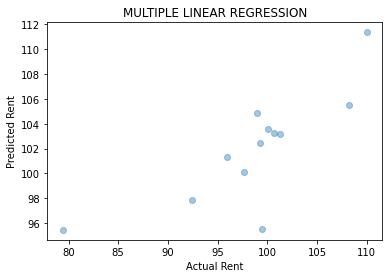

In [81]:
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [82]:
print(mlr.coef_) #회귀모델의 계수

[[-0.0238983   0.01616599 -0.01993463  0.00703688 -0.03759444 -0.10845262
  -0.0303749 ]]


In [83]:
print(mlr.score(X_train, y_train)) #모델의 결정계수
# 91%를 해당변수들로 설명할 수 있다.(train, test split 분할 고정하지않아서 값이 변함.)

0.9165312111514448
